### Installing packages

In [94]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install geopandas
!pip install shapely


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached geopandas-0.12.1-py3-none-any.whl (1.1 MB)
  Using cached Fiona-1.8.22.tar.gz (1.4 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [2 lines of output]
      Failed to get options via gdal-config: [Errno 2] No such file or directory: 'gdal-config'
      A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-gene

In [12]:
!pip install pdfminer.six


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


### Scraping data from pdfs

In [40]:
import pandas as pd
import re
from pdfminer.high_level import extract_text, LAParams

Cleaning pdf

In [41]:
text = extract_text("oct22.pdf", laparams = LAParams(boxes_flow=None))
print(text)

TOMPKINS COUNTY SHERIFFS
OFFICE
Public Information Log

Domestic

Incident Address:  ENFIELD FALLS RD; T ITHACA

ITHACA NY 14850

Time Reported:  23:32:09

Time Occurred Between:  23:32:09 10/31/22 - 23:34:07 10/31/22

Traffic Offense

Incident Address:  BLOCK TRUMANSBURG RD; T ITHACA

ITHACA NY 14850

Time Reported:  23:19:50

Time Occurred Between:  23:19:50 10/31/22 - 23:19:50 10/31/22

Traffic Offense

Incident Address:  STATE ROUTE 13 & WILLOW AVE; C ITHACA

ITHACA NY 14850

Time Reported:  23:09:41

Time Occurred Between:  23:09:41 10/31/22 - 23:09:41 10/31/22

Traffic Stop

Alarm Police

Incident Address:  PLEASANT VALLEY RD; T GROTON
GROTON NY 13073

Time Reported:  23:04:56

Time Occurred Between:  23:04:56 10/31/22 - 23:06:10 10/31/22

Alarm activation

Traffic Offense

Incident Address:  STATE ROUTE 13 N & N TRIPHAMMER RD; V LANSING

ITHACA NY 14850

Time Reported:  22:55:28

Time Occurred Between:  22:55:28 10/31/22 - 22:55:28 10/31/22

11/01/22

Public Information Log

Tr

In [42]:
ts = text.split('\n')
ts = [i for i in ts if i != '']

f = open('clean.txt', 'w')
for i in ts:
    # remove hex characters
    line = re.sub(r'[^\x00-\x7f]',r'', i) 

    # heuristical skipping
    if i in ['TOMPKINS COUNTY SHERIFFS','OFFICE', 'Public Information Log', 'Public Information Log']:
        continue
    if i[:4] == 'Page':
        continue
    if i[0].isdigit():
        continue
            
    print(line, file=f)

f.close()

Need to process some things manually after - very first reason doesn't appear for some reason

In [43]:
reasons = []
incident_address = []
time_reported = []
time_occured = []
comments = []

if_last_is_incident = False
if_last_time_occured = True

tot = ""
prev = ""
with open('clean.txt', 'r') as f:
    for ind, line in enumerate(f.readlines()):
        line = line.strip()
        
        first_colon = line.find(':')

        # heuristic adding to 
        if first_colon != -1:
            before = line[:first_colon]
            after = line[first_colon + 1:]
            if before == 'Incident Address':
                
                # append previous comments if not start as well as next reason
                if ind != 1:
                    comments.append(tot)
                reasons.append(prev)
                tot = ""
                prev = ""
                if_last_time_occured = False


                incident_address.append(after)

                if_last_is_incident = True

            elif before == 'Time Reported':
                if_last_is_incident = False
                time_reported.append(after)
            elif before == 'Time Occurred Between':
                time_occured.append(after)
                if_last_time_occured = True
        else:
            if if_last_is_incident:
                # Add to address
                incident_address[-1] += ' ' + line
            elif if_last_time_occured:
                tot += " " + prev
                prev = line
            # if first line
            elif ind == 0:
                prev = line

            else:
                pass
    comments.append(tot)
len(incident_address), len(time_reported), len(time_occured), len(reasons), len(comments)

(1841, 1841, 1841, 1841, 1841)

In [44]:
df = pd.DataFrame.from_dict({
    'reasons' : reasons,
    'time_occured' : time_occured,
    'time_reported' : time_reported,
    'comments' : comments,
    'incident_address' : incident_address
})


In [45]:
df.to_csv('oct22_cleaned.csv')

Cleaning csvs

In [46]:
f = pd.read_csv('oct22accidents.csv')

In [47]:
f.columns = f.iloc[1]

In [48]:
f.dropna(how='all', axis=1, inplace=True)

In [49]:
f.drop([0,1], inplace=True)
f.to_csv('clean.csv')

In [50]:
f.to_csv('accidents_cleaned.csv')

### Getting coords for Tompkins County

In [10]:
import json

with open('tompkins-county-coords.json', 'r') as f:
    coords = json.load(f)
coords = coords['coordinates'][0]
coords = [(i,j) for i,j in coords]
coords

[(-76.585989, 42.54991),
 (-76.586538, 42.550175),
 (-76.588873, 42.551303),
 (-76.593778, 42.553668),
 (-76.597834, 42.555596),
 (-76.600887, 42.557047),
 (-76.603346, 42.558188),
 (-76.605987, 42.559413),
 (-76.606694, 42.559808),
 (-76.612027, 42.562783),
 (-76.612174, 42.562865),
 (-76.616286, 42.565432),
 (-76.616696, 42.565688),
 (-76.618239, 42.566652),
 (-76.622875, 42.570692),
 (-76.624439, 42.572055),
 (-76.624667, 42.572253),
 (-76.626761, 42.573868),
 (-76.629357, 42.576273),
 (-76.632496, 42.579182),
 (-76.638075, 42.584404),
 (-76.639216, 42.585472),
 (-76.644424, 42.590795),
 (-76.645317, 42.591708),
 (-76.647666, 42.594419),
 (-76.649649, 42.596708),
 (-76.650231, 42.597379),
 (-76.651716, 42.599216),
 (-76.654228, 42.602325),
 (-76.656226, 42.604798),
 (-76.658634, 42.608413),
 (-76.660242, 42.610827),
 (-76.663139, 42.616354),
 (-76.663556, 42.617149),
 (-76.666543, 42.623457),
 (-76.646243, 42.624292),
 (-76.646039, 42.624294),
 (-76.645709, 42.624304),
 (-76.645507,

Plotting coords

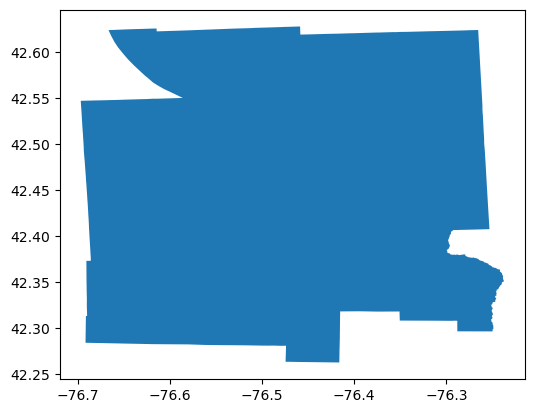

In [25]:

from shapely import geometry
import matplotlib.pyplot as plt
import geopandas as gpd

tompkinscounty = geometry.Polygon(coords)

p = gpd.GeoSeries(tompkinscounty)
p.plot()
plt.show()

In [21]:
x, y  = [i for i, _ in coords], [j for _,j in coords]
up_right_corner = max(x), max(y)
down_left_corner = min(x), min(y)

In [31]:
import numpy as np
def gen_random_point_in_polygon(polygon):
    rand_x = np.random.uniform(down_left_corner[0], up_right_corner[0])
    rand_y = np.random.uniform(down_left_corner[1], up_right_corner[1])

    rand_point = geometry.Point(rand_x, rand_y)
    if polygon.contains(rand_point):
        return rand_point
    else:
        return gen_random_point_in_polygon(polygon)

AttributeError: 'DataFrame' object has no attribute 'crs'

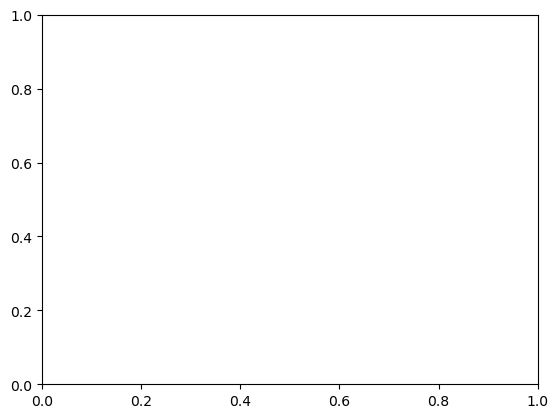

In [34]:
sample_rand_point = gen_random_point_in_polygon(tompkinscounty)

p = gpd.GeoDataFrame([tompkinscounty, sample_rand_point])
p.plot()
plt.show()